---
title: "Makemore multi layer perceptron"
format: 
    gfm:
        echo: false
jupyter: python3
---

In this post, I build a [multi layer perceptron](https://www.youtube.com/watch?v=TCH_1BHY58I) architecture for makemore.

I am experimenting with blogging directly in a Juptyer notebook using [quarto](https://quarto.org/) rather than writing a notebook and taking duplicate notes in a markdown doc.

## Preparing datasets 

Let's start by reading in an input list of words and preparing our training, dev, test datasets.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pprint
import random
import torch
import torch.nn.functional as F
from tqdm import tqdm
pp = pprint.PrettyPrinter()

%matplotlib inline

In [2]:
#| echo: true
filename = 'names.txt'

def get_names():
    names = []
    for line in open(filename, 'r'):
        if line.startswith('#'):
            continue
        name = line.strip().lower()
        if not name or not name.isalpha:
            continue
        names.append(name)
    return names

words = get_names()
print(words[:10])

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


Then, we write some helpers to convert between letters and numerical indexes.

In [3]:
#| echo: true
letters = '.' + ''.join(sorted(set(''.join(words))))
num_letters = len(letters)

itol = {i: l for i, l in enumerate(letters)}
ltoi = {l: i for i, l in enumerate(letters)}

print(letters)

.abcdefghijklmnopqrstuvwxyz


And a helper function to turn words into tensors.

In [4]:
#| echo: true
context_size = 3 # how many letters do we see to predict the next one

def build_dataset(words):
    X, Y = [], []
    for word in words:
        # takes advantage of the fact itos[0] == '.'
        context = [0] * context_size

        for ch in word + '.':
            X.append(context)
            ix = ltoi[ch]
            Y.append(ix)

            context = context[1:] + [ix]

    return torch.tensor(X), torch.tensor(Y)

# sanity check the function
xx, yy = build_dataset(['emma'])
pp.pprint(list(zip(xx, yy)))

[(tensor([0, 0, 0]), tensor(5)),
 (tensor([0, 0, 5]), tensor(13)),
 (tensor([ 0,  5, 13]), tensor(13)),
 (tensor([ 5, 13, 13]), tensor(1)),
 (tensor([13, 13,  1]), tensor(0))]


Let's now prepare the training, dev and test datasets.

- Training - 80% of our data. Used to train the model
- Dev - 10% of our data. Used to evaluate the model, to verify that the model isn't overfitting and to tune hyperparameters.
- Test - 10% of our data. Used to check that the model is going to work on never before seen data.

In [5]:
#| echo: true
import random

random.seed(42)
random.shuffle(words)

n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

In [6]:
#| echo: true
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

print("train shape", Xtr.shape)
print("dev shape", Xdev.shape)
print("test shape", Xtest.shape)

assert Xtr.shape[0], Ytr.shape[0]
assert Xtr.dtype == Ytr.dtype == torch.int64

train shape torch.Size([182625, 3])
dev shape torch.Size([22655, 3])
test shape torch.Size([22866, 3])


Our datasets are ready.

## Neural network setup 

Let's train the multi layer perceptron and evaluate the network.

In [12]:
#| echo: true
#| output: false
batch_size = 6

# changed these parameters 10 times to achieve the best loss on the dev set
training_iter = 300000
word_embedding_size = 8
hidden_layer_size = 180

class MLP:
    """MLP refers to a multi layer perception model

    This class lets us run the forward and backward pass many times 
    without having to copy/paste the tensor manipulation code many times"""
    def __init__(self):
        # C maps each letter to its embedding
        self.C = torch.randn((num_letters, word_embedding_size), requires_grad=True)

        # W1, B1 are parameters for the embedding layer -> hidden layer
        self.W1 = torch.randn((context_size * word_embedding_size, hidden_layer_size), requires_grad=True)
        self.B1 = torch.randn((hidden_layer_size,), requires_grad=True)

        # W2, B2 are parameters for the hidden layer -> output layer
        self.W2 = torch.randn((hidden_layer_size, num_letters), requires_grad=True)
        self.B2 = torch.randn((num_letters,), requires_grad=True)

        # W3 is a parmeter for a direct connection from the embedding layer to the output
        # this is a technique recommended in the paper
        self.W3 = torch.randn((word_embedding_size * context_size, num_letters), requires_grad=True)

        self.params = [self.C, self.W1, self.B1, self.W2, self.B2, self.W3]

    def __call__(self, X: torch.Tensor):
        # E is the embedding layer
        # the shape of this is num_letters * context_size * word_embedding_size
        E = self.C[X].view(-1, context_size * word_embedding_size) 

        # H is the hidden layer
        H = E @ self.W1 + self.B1

        # logits from the output layer
        logits = H.tanh() @ self.W2 + self.B2 + (E @ self.W3)
        return logits
    
    def zero_grad(self):
        for param in self.params:
            param.grad = None

    def optim_step(self, lr: float):
        for param in self.params:
            param.data += -lr * param.grad

    def weight_decay_value(self, c: float): # this is the regularization term
        return c * ((self.W1 ** 2).mean() + (self.W2 ** 2).mean() + (self.W3 ** 2).mean())


m = MLP()

100%|██████████| 300000/300000 [01:47<00:00, 2793.38it/s]


tensor(2.6985, grad_fn=<AddBackward0>)


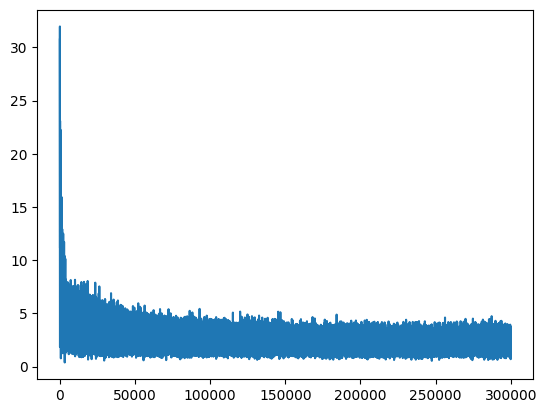

In [13]:
#| echo: true
#| output: false
lossi = []

for i in tqdm(range(training_iter)):
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    X = Xtr[ix]
    Y = Ytr[ix]

    O = m(X)
    loss = F.cross_entropy(O, Y) + m.weight_decay_value(0.1)

    m.zero_grad()
    loss.backward()

    lr = 0.1 if i < training_iter // 2 else 0.01
    m.optim_step(lr)
    lossi.append(loss.data)

print(loss)
plt.plot(lossi)

Let's look at the loss on the dev set.

We are trying to beat a loss of 2.2 from the lecture.

In [14]:
#| echo: true
# Dev set loss
print(F.cross_entropy(m(Xdev), Ydev))

tensor(2.1850, grad_fn=<NllLossBackward0>)


We beat it just barely.

To beat the loss from the lecture, I tried various values of `word_embedding_size`, `hidden_layer_size` and added in an extra `W3` matrix for a direct connection from the embedding layer to the output layer.

Let's check our test set loss for sanity.

In [15]:
#| echo: true
# Test set loss
print(F.cross_entropy(m(Xtest), Ytest))

tensor(2.1846, grad_fn=<NllLossBackward0>)


Test loss is pretty close to dev loss. This is good because it means that our dev set performance is generalizing on the test set too.

## Generate new words

Let's see what kinds of words our model generates.

In [22]:
#| echo: true
#| code-fold: true
g = torch.Generator().manual_seed(0)

for i in range(10):
    
    context = [0] * context_size
    word = ''

    while True:
        logits = m(torch.tensor(context))
        # sanity check
        assert logits.shape == (1, num_letters)

        probs = logits.softmax(dim=1)
        # sanity check
        np.testing.assert_almost_equal(probs[0].sum().item(), 1, decimal=3)

        next_letter_ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g)
        letter = itol[next_letter_ix.item()]

        if letter == '.':
            break

        word += letter
        context = context[1:] + [ next_letter_ix ]
    print(word)

zilynn
emela
leigh
raudialettaria
julipfeana
jobynn
bus
kiani
azia
sauro


I'd say these are half decent. Definitely far from random. Our model did learn something after all.